# Необходимые библиотеки

In [1]:
from collections import defaultdict
import numpy as np
import random
import asyncio
import itertools
import matplotlib.pyplot as plt
from math import sqrt
from scipy.spatial.distance import pdist, squareform, euclidean
from scipy.special import gamma
from itertools import combinations, product
from sklearn.cluster import DBSCAN, OPTICS
import csv
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

# Константы

In [2]:
epsilon = 0.05

N = 5
WINDOW_MIN = 8
WINDOW = 15

WISHART_K = 4
WISHART_H = 0.2

STEPS, EPS = 30, 0.05

Q_VALUE = 0.99

# Генерация ряда Лоренца

In [3]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        x_0, y_0, z_0 = 1, 1, 1

        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

In [4]:
xs, _, _ = Lorentz().generate(0.1, 10399)
xs = (xs - xs.min()) / (xs.max() - xs.min())

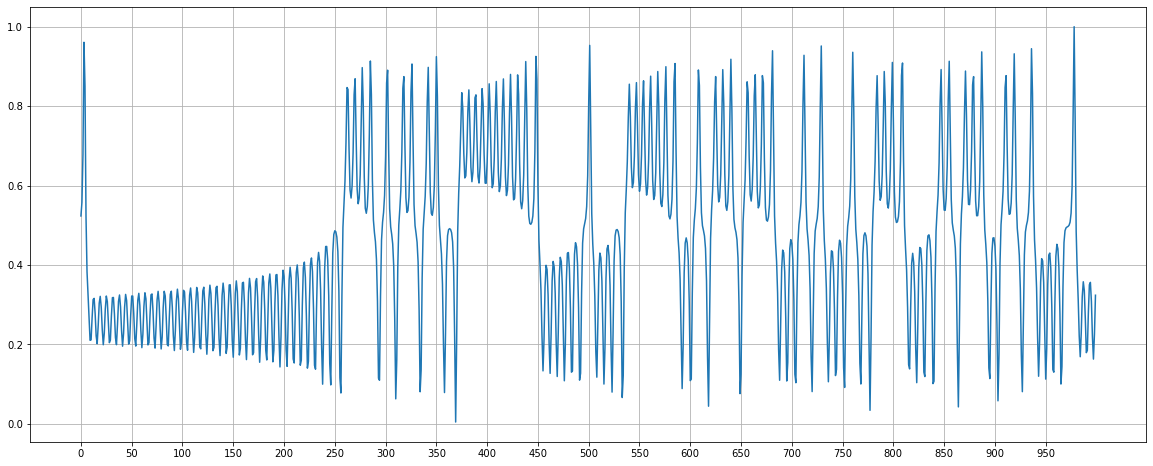

In [5]:
plt.figure(figsize=(20, 8))
plt.plot(xs[:1000])
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()

In [6]:
list_for_delete = []
for i in range(300):
    list_for_delete.append(i)

xs = np.delete(xs, list_for_delete)

xs_train, xs_test = np.split(xs, [10000])
print(len(xs_train), len(xs_test))

10000 100


In [7]:
'''import csv
with open('xs_test.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(xs_test)'''

"import csv\nwith open('xs_test.csv', 'w', newline='') as myfile:\n     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)\n     wr.writerow(xs_test)"

# Функции

In [8]:
import itertools

def generate_subsequences(window, num, short=False):
    values = list(range(window))
    result = []
    if short:
        for subseq in itertools.combinations(values, num):
            diff = WINDOW - WINDOW_MIN
            result.append(tuple([num + diff for num in subseq]))
    else:
        for subseq in itertools.combinations(values, num):
            result.append(subseq)
    
    return result

In [9]:
def str_subseq(subseq):
    if not subseq:
        return '<None>'
    return ','.join(map(str, subseq))

def gen_sample_in_point(values, window, pattern, pos):
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None

def gen_sample_in_point_with_q(values, window, pattern, pos):
    # наложить шаблон 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos][0] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val[0] == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None
    
def generate_sample(values, window, pattern, put_none=False):
    result = []
    for i in range(len(values)):
        res = gen_sample_in_point(values, window, pattern, i)
        if res == None:
            if put_none:
                result.append(res)
        else:
            result.append(res)
    return result

def aggr(pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts))
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

In [10]:
def generate_patterns():
    patterns1 = generate_subsequences(WINDOW_MIN - 1, N - 1, short=True)
    patterns2 = generate_subsequences(WINDOW - 1, N - 1)
    patterns3 = random.choices(patterns2[300:], k=35)
    
    return patterns1 + patterns3

In [11]:
def volume(r, m):
    return np.pi ** (m / 2) * r ** m / gamma(m / 2 + 1)

def significant(cluster, h, p):
    max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))

    return max_diff >= h

def partition(dist, l, r, order):
    if l == r:
        return l

    pivot = dist[order[(l + r) // 2]]
    left, right = l - 1, r + 1
    while True:
        while True:
            left += 1
            if dist[order[left]] >= pivot:
                break

        while True:
            right -= 1
            if dist[order[right]] <= pivot:
                break

        if left >= right:
            return right

        order[left], order[right] = order[right], order[left]

def nth_element(dist, order, k):
    l, r = 0, len(order) - 1
    while True:
        if l == r:
            break
        m = partition(dist, l, r, order)
        if m < k:
            l = m + 1
        elif m >= k:
            r = m

def get_clustering(x, k, h, verbose=True):
    n = len(x)
    if isinstance(x[0], list):
        m = len(x[0])
    else:
        m = 1
    dist = squareform(pdist(x))

    dk = []
    for i in range(n):
        order = list(range(n))
        nth_element(dist[i], order, k - 1)
        dk.append(dist[i][order[k - 1]])

    p = [k / (volume(dk[i], m) * n) for i in range(n)]

    w = np.full(n, 0)
    completed = {0: False}
    last = 1
    vertices = set()
    for d, i in sorted(zip(dk, range(n))):
        neigh = set()
        neigh_w = set()
        clusters = defaultdict(list)
        for j in vertices:
            if dist[i][j] <= dk[i]:
                neigh.add(j)
                neigh_w.add(w[j])
                clusters[w[j]].append(j)

        vertices.add(i)
        if len(neigh) == 0:
            w[i] = last
            completed[last] = False
            last += 1
        elif len(neigh_w) == 1:
            wj = next(iter(neigh_w))
            if completed[wj]:
                w[i] = 0
            else:
                w[i] = wj
        else:
            if all(completed[wj] for wj in neigh_w):
                w[i] = 0
                continue
            significant_clusters = set(wj for wj in neigh_w if significant(clusters[wj], h, p))
            if len(significant_clusters) > 1:
                w[i] = 0
                for wj in neigh_w:
                    if wj in significant_clusters:
                        completed[wj] = (wj != 0)
                    else:
                        for j in clusters[wj]:
                            w[j] = 0
            else:
                if len(significant_clusters) == 0:
                    s = next(iter(neigh_w))
                else:
                    s = next(iter(significant_clusters))
                w[i] = s
                for wj in neigh_w:
                    for j in clusters[wj]:
                        w[j] = s
    return w

In [12]:
from itertools import groupby

def generate_centers(x_trains, WISHART_K=4, WISHART_H=0.2):
    ws = {}
    for pattern, train in x_trains.items():
        ws[pattern] = get_clustering(train, WISHART_K, WISHART_H)

    centers = {}
    
    for pattern, w in ws.items():
        sorted_by_cluster = sorted(range(len(w)), key=lambda x: w[x])
        for wi, cluster in groupby(sorted_by_cluster, lambda x: w[x]):
            cluster = list(cluster)
            center = np.full(N, 0.0)
            for i in cluster:

                center += x_trains[pattern][i]
            centers.setdefault(pattern, []).append(center / len(cluster))

    return centers

In [13]:
def clusters_create_dbscan(data_0):
    data = []
    for i in data_0:
        data.append([i, 0])
    clustering = DBSCAN(eps=0.01, min_samples=2).fit(data)
    labels = clustering.labels_
    labels = labels.tolist()
    
    lens = max(labels)
    clusters = []
    for i in range(lens + 2):
        clusters.append([])
        
    for i in range(len(data)):
        clusters[labels[i] + 1].append(data[i])
    
    maxim = 0
    max_len = 0
    for i in range(len(clusters)):
        if len(clusters[i]) > max_len:
            maxim = i
            max_len = len(clusters[i])

    return np.average(clusters[maxim])

In [14]:
def clusters_create_optics(data_0):
    data = []
    for i in data_0:
        data.append([i, 0])
    clustering = OPTICS(min_samples=2).fit(data)
    labels = clustering.labels_
    labels = labels.tolist()
    
    lens = max(labels)
    clusters = []
    for i in range(lens + 2):
        clusters.append([])
        
    for i in range(len(data)):
        clusters[labels[i] + 1].append(data[i])
    
    maxim = 0
    max_len = 0
    for i in range(len(clusters)):
        if len(clusters[i]) > max_len:
            maxim = i
            max_len = len(clusters[i])
    
    return np.average(clusters[maxim])

In [15]:
def make_prediction_with(p, q, method="DBSCAN"):
    lists_with_list_with_predicted_values = [0] * int(len(p))
    for i in range(len(lists_with_list_with_predicted_values)):
        lists_with_list_with_predicted_values[i] = []

    for i in range(len(p)):
        for j in q:
            if len(j) <= (len(p) - i):
                counter = 0
                counter_for_missed_points = 0
                for k in range(len(j)): 
                    if j[k]:
                        if not p[i + k]:
                            counter_for_missed_points += 1
                        else:
                            if abs(float(p[i + k]) - float(j[k])) <= epsilon:
                                counter += 1
                if (counter >= len(j) - counter_for_missed_points) and (counter > 1):
                    for k in range(len(j)):
                        lists_with_list_with_predicted_values[i + k].append(float(j[k]))
    for i in range(len(lists_with_list_with_predicted_values)):
        print(lists_with_list_with_predicted_values[i])
        if len(lists_with_list_with_predicted_values[i]) == 0:
            lists_with_list_with_predicted_values[i] = False
        else:
            if method == "DBSCAN":
                lists_with_list_with_predicted_values[i] = clusters_create_dbscan(lists_with_list_with_predicted_values[i]) * 2
            elif method == "OPTICS":
                lists_with_list_with_predicted_values[i] = clusters_create_optics(lists_with_list_with_predicted_values[i]) * 2
            else:
                print("unknown method")
                return None, None
    return lists_with_list_with_predicted_values, lists_with_list_with_predicted_values.count(False)

# Убираем точки в xs_test

In [16]:
def remove_points(my_list, percentage):
    new_list = [0] * len(my_list)
    todrop = random.sample(range(len(my_list)), len(my_list) - round(len(my_list)*percentage))
    for i in range(len(my_list)):
        if i not in todrop:
            new_list[i] = False
        else:
            new_list[i] = my_list[i]
    return new_list

In [17]:
i = 0
xs_test_real = [0] * len(xs_test)

for x in xs_test:
    xs_test_real[i] = xs_test[i] 
    i += 1

In [18]:
xs_test_10 = remove_points(xs_test_real, 0.1)
xs_test_20 = remove_points(xs_test_real, 0.2)
xs_test_30 = remove_points(xs_test_real, 0.3)
xs_test_40 = remove_points(xs_test_real, 0.4)
xs_test_50 = remove_points(xs_test_real, 0.5)
xs_test_60 = remove_points(xs_test_real, 0.6)
xs_test_70 = remove_points(xs_test_real, 0.7)
xs_test_80 = remove_points(xs_test_real, 0.8)
xs_test_90 = remove_points(xs_test_real, 0.9)

In [19]:
def change_points(xs):
    xs_res = [0] * len(xs)

    for i in range(len(xs)):
        xs_res[i] = xs[i]
        
    for j in range(len(xs_res)):
        if (random.randrange(2) and xs_res[j]):
            if random.randrange(2):
                xs_res[j] += random.uniform(0, 0.03) 
            else: 
                xs_res[j] -= random.uniform(0, 0.03) 
    return xs_res

In [20]:
xs_test_10_c = change_points(xs_test_10)
xs_test_20_c = change_points(xs_test_20)
xs_test_30_c = change_points(xs_test_30)
xs_test_40_c = change_points(xs_test_40)
xs_test_50_c = change_points(xs_test_50)
xs_test_60_c = change_points(xs_test_60)
xs_test_70_c = change_points(xs_test_70)
xs_test_80_c = change_points(xs_test_80)
xs_test_90_c = change_points(xs_test_90)

# Создаем массив шаблонов

In [21]:
def create_pat(xs, size_of_pattern, lenght_of_pattern):
    list_of_index = list(range(len(xs)))

    list_of_tuples_with_index = []
    list_with_values = []
    l = list(combinations(range(lenght_of_pattern - 1), size_of_pattern - 1))
    
    for j in range(len(list_of_index) - lenght_of_pattern - 1):
        a = []
        
        for i in range(len(l)):
            b = [False] * lenght_of_pattern
            b[0] = xs[j]
            for k in l[i]:
                b[k + 1] = xs[j + k + 1]
            a.append(b)
        list_with_values += a
        
    return list_with_values

In [22]:
'''ЭТО ВМЕСТО ЧТЕНИЯ ФАЙЛА patterns.csv

x_trains = {}
patterns = generate_patterns()

for pattern in patterns:
    key = str_subseq(pattern + (WINDOW - 1,))
   
   x_trains[key] = generate_sample(xs_train, WINDOW, pattern, put_none=False)'''

'ЭТО ВМЕСТО ЧТЕНИЯ ФАЙЛА patterns.csv\n\nx_trains = {}\npatterns = generate_patterns()\n\nfor pattern in patterns:\n    key = str_subseq(pattern + (WINDOW - 1,))\n   \n   x_trains[key] = generate_sample(xs_train, WINDOW, pattern, put_none=False)'

In [23]:
'''%%time

centers = generate_centers(x_trains)'''

'%%time\n\ncenters = generate_centers(x_trains)'

In [24]:
'''patterns = []

for i in centers:
   current_index = list(map(int, i.split(',')))
   for j in centers[i]:
       j = j.tolist()
       current_tuple = [False] * (current_index[-1] - current_index[0] + 1)
       
       p = 0
       for k in j:
           current_tuple[current_index[p] - current_index[0]] = k
           p += 1
       patterns.append(current_tuple)'''

"patterns = []\n\nfor i in centers:\n   current_index = list(map(int, i.split(',')))\n   for j in centers[i]:\n       j = j.tolist()\n       current_tuple = [False] * (current_index[-1] - current_index[0] + 1)\n       \n       p = 0\n       for k in j:\n           current_tuple[current_index[p] - current_index[0]] = k\n           p += 1\n       patterns.append(current_tuple)"

In [25]:
with open('out.csv', newline='') as f:
    reader = csv.reader(f)
    patterns0 = list(reader)
patterns1 = []

for x in patterns0:
    y = []
    for obj in x:
        if obj != 'False':
            obj = float(obj)
        else:
            obj = False
        y.append(obj)
    patterns1.append(y)

In [26]:
with open('patterns.csv', newline='') as f:
    reader = csv.reader(f)
    patterns0 = list(reader)
patterns = []

for x in patterns0:
    y = []
    for obj in x:
        if obj != 'False':
            obj = float(obj)
        else:
            obj = False
        y.append(obj)
    patterns.append(y)

# Визуализация результатов

In [27]:
def visualisation(s_predicted, xs_test_real):
    k = []
    for i in range(len(s_predicted)):
        k.append(i)
    plt.figure(figsize=(20, 8))
    plt.scatter(k, s_predicted, label='Predicted values', edgecolors='r')
    plt.plot(xs_test_real, label='Actual values')
    plt.xticks([i for i in range(0, 100, 50)])
    plt.grid()
    plt.legend(loc='lower right',fontsize='xx-large')
    
    plt.show()
    
def visualisation_series(predicted_list, xs_test_real):
    k = []
    for i in range(len(predicted_list[0])):
        k.append(i)    
    fig, ax = plt.subplots(2, 1, figsize=(20,10))
    fig.tight_layout()
    
    ax[0].scatter(k, predicted_list[0], label='Predicted values', edgecolors='r')
    ax[0].plot(xs_test_real, color='blue', label='Actual values')
    ax[0].legend()
    ax[0].grid()
    
    ax[1].scatter(k, predicted_list[-1], label='Predicted values', edgecolors='r')
    ax[1].plot(xs_test_real, color='blue', label='Actual values')
    ax[1].legend()
    ax[1].grid()
    
    plt.show()

In [28]:
def visualisation_points(res):
    plt.figure(figsize=(20, 8))
    plt.plot(res)
    plt.grid() 
    
    plt.show()

In [29]:
def visualisation_metrics(metrics):
    fig, ax = plt.subplots(2, 2, figsize=(20, 8))
    fig.tight_layout()
    mse, rmse, mae, mape = metrics
    
    ax[0, 0].plot(mse, color='red', label='MSE')
    ax[0, 0].legend()
    ax[0, 1].plot(rmse, color='blue', label='RMSE')
    ax[0, 1].legend()
    ax[1, 0].plot(mae, color='green', label='MAE')
    ax[1, 0].legend()
    ax[1, 1].plot(mape, color='purple', label='MAPE')
    ax[1, 1].legend()

    plt.show()
    
def visualisation_metrics_2(metrics_1, metrics_2):
    fig, ax = plt.subplots(2, 2, figsize=(20, 8))
    fig.tight_layout()
    mse, rmse, mae, mape = metrics_1
    mse_s, rmse_s, mae_s, mape_s = metrics_2
    
    ax[0, 0].plot(mse, color='red', label='MSE')
    ax[0, 0].plot(mse_s, color='blue', label='MSE_s')
    ax[0, 0].legend()
    ax[0, 1].plot(rmse, color='red', label='RMSE')
    ax[0, 1].plot(rmse_s, color='blue', label='RMSE_s')
    ax[0, 1].legend()
    ax[1, 0].plot(mae, color='red', label='MAE')
    ax[1, 0].plot(mae_s, color='blue', label='MAE_s')
    ax[1, 0].legend()
    ax[1, 1].plot(mape, color='red', label='MAPE')
    ax[1, 1].plot(mape_s, color='blue', label='MAPE_s')
    ax[1, 1].legend()

    plt.show()

# Предсказание с обработкой непрогнозируемых точек

In [30]:
def update_metrics(s_predicted_, xs_test_real, metrics):
    metrics[0].append(mean_squared_error(xs_test_real, s_predicted_))
    metrics[1].append(mean_squared_error(xs_test_real, s_predicted_, squared=False))
    metrics[2].append(mean_absolute_error(xs_test_real, s_predicted_))
    metrics[3].append(mean_absolute_percentage_error(xs_test_real, s_predicted_))
    return metrics

In [31]:
def main_predict(xs_test_, xs_test_real, mode="default", cluster="dbscan"):
    i = 0
    res = []
    all_list = []
    
    metrics = [[],[],[],[]]
    
    s_xs_test_ = xs_test_    
    res.append(xs_test_.count(False))
    all_list.append(s_xs_test_)
    
    metrics = update_metrics(s_xs_test_, xs_test_real, metrics)
    
    while (i < STEPS):
        if (i >= 30):
            print(i)
        
        if cluster == "dbscan":
            s_predicted_, mist_ = make_prediction_with(s_xs_test_, patterns)
        elif cluster == "optics":
            s_predicted_, mist_ = make_prediction_with(s_xs_test_, patterns, method="OPTICS")
        
        if mode == "static":
            for j in range(len(s_predicted_)):
                if xs_test_[j]:
                    s_predicted_[j] = xs_test_[j]
        elif mode == "h_static":
            for k in range(len(s_predicted_)):
                if xs_test_[k]:
                    s_predicted_[k] = s_predicted_[k] * 0.8 + s_xs_test_[k] * 0.2
                '''elif s_xs_test_[k]:
                    s_predicted_[k] = s_predicted_[k] * 0.8 + s_xs_test_[k] * 0.2'''
        
        s_xs_test_ = s_predicted_
        res.append(mist_)
        all_list.append(s_predicted_)
        metrics = update_metrics(s_xs_test_, xs_test_real, metrics)
        i += 1
        
    return res, all_list, metrics

# идеальный ряд с фиксацией

In [32]:
res_10, all_list_10, metrics_10 = main_predict(xs_test_10, xs_test_real, mode="static")

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


KeyboardInterrupt: 

In [ ]:
visualisation_series(all_list_10, xs_test_real)

In [ ]:
%%time

res_50, all_list_50, metrics_50 = main_predict(xs_test_50, xs_test_real, mode="static")

In [ ]:
visualisation_series(all_list_50, xs_test_real)

In [ ]:
%%time

res_90, all_list_90, metrics_90 = main_predict(xs_test_90, xs_test_real, mode="static")

In [ ]:
visualisation_series(all_list_90, xs_test_real)

# поломанный ряд с фиксаций

In [ ]:
%%time

res_10_c, all_list_10_c, metrics_10_c = main_predict(xs_test_10_c, xs_test_real, mode="static")

In [ ]:
visualisation_series(all_list_10_c, xs_test_real)

In [ ]:
%%time

res_50_c, all_list_50_c, metrics_50_c = main_predict(xs_test_50_c, xs_test_real, mode="static")

In [ ]:
visualisation_series(all_list_50_c, xs_test_real)

In [ ]:
%%time

res_90_c, all_list_90_c, metrics_90_c = main_predict(xs_test_90_c, xs_test_real, mode="static")

In [ ]:
visualisation_series(all_list_90_c, xs_test_real)

# поломанный ряд с псевдо-фиксаций

In [ ]:
%%time

res_10_ch, all_list_10_ch, metrics_10_ch = main_predict(xs_test_10_c, xs_test_real, mode="h_static")
res_50_ch, all_list_50_ch, metrics_50_ch = main_predict(xs_test_50_c, xs_test_real, mode="h_static")
res_90_ch, all_list_90_ch, metrics_90_ch = main_predict(xs_test_90_c, xs_test_real, mode="h_static")

# визуализция рядов до и после

In [ ]:
visualisation_series(all_list_10_ch, xs_test_real)

In [ ]:
visualisation_series(all_list_50_ch, xs_test_real)

In [ ]:
visualisation_series(all_list_90_ch, xs_test_real)

# проверки метрик

In [ ]:
visualisation_metrics_2(metrics_10, metrics_10_c)

In [ ]:
visualisation_metrics_2(metrics_50, metrics_50_c)

In [ ]:
visualisation_metrics_2(metrics_90, metrics_90_c)

In [ ]:
visualisation_metrics_2(metrics_10_c, metrics_10_ch)

In [ ]:
visualisation_metrics_2(metrics_50_c, metrics_50_ch)

In [ ]:
visualisation_metrics_2(metrics_90_c, metrics_90_ch)

# проверки непрогнозируемых точек

In [ ]:
visualisation_points(res_10)

In [ ]:
visualisation_points(res_50)

In [ ]:
visualisation_points(res_90)

In [ ]:
visualisation_points(res_10_c)

In [ ]:
visualisation_points(res_50_c)

In [ ]:
visualisation_points(res_90_c)

In [ ]:
visualisation_points(res_10_ch)

In [ ]:
visualisation_points(res_50_ch)

In [ ]:
visualisation_points(res_90_ch)

# допрогнозирование всех

In [ ]:
%%time

res_20, all_list_20, metrics_20 = main_predict(xs_test_20, xs_test_real, mode="static")
res_30, all_list_30, metrics_30 = main_predict(xs_test_30, xs_test_real, mode="static")
res_40, all_list_40, metrics_40 = main_predict(xs_test_40, xs_test_real, mode="static")
res_60, all_list_60, metrics_60 = main_predict(xs_test_60, xs_test_real, mode="static")
res_70, all_list_70, metrics_70 = main_predict(xs_test_70, xs_test_real, mode="static")
res_80, all_list_80, metrics_80 = main_predict(xs_test_80, xs_test_real, mode="static")

In [ ]:
%%time

res_20_c, all_list_20_c, metrics_20_c = main_predict(xs_test_20_c, xs_test_real, mode="static")
res_30_c, all_list_30_c, metrics_30_c = main_predict(xs_test_30_c, xs_test_real, mode="static")
res_40_c, all_list_40_c, metrics_40_c = main_predict(xs_test_40_c, xs_test_real, mode="static")
res_60_c, all_list_60_c, metrics_60_c = main_predict(xs_test_60_c, xs_test_real, mode="static")
res_70_c, all_list_70_c, metrics_70_c = main_predict(xs_test_70_c, xs_test_real, mode="static")
res_80_c, all_list_80_c, metrics_80_c = main_predict(xs_test_80_c, xs_test_real, mode="static")

In [ ]:
%%time

res_20_ch, all_list_20_ch, metrics_20_ch = main_predict(xs_test_20_c, xs_test_real, mode="h_static")
res_30_ch, all_list_30_ch, metrics_30_ch = main_predict(xs_test_30_c, xs_test_real, mode="h_static")
res_40_ch, all_list_40_ch, metrics_40_ch = main_predict(xs_test_40_c, xs_test_real, mode="h_static")
res_60_ch, all_list_60_ch, metrics_60_ch = main_predict(xs_test_60_c, xs_test_real, mode="h_static")
res_70_ch, all_list_70_ch, metrics_70_ch = main_predict(xs_test_70_c, xs_test_real, mode="h_static")
res_80_ch, all_list_80_ch, metrics_80_ch = main_predict(xs_test_80_c, xs_test_real, mode="h_static")

# различные визуализации

In [ ]:
def total_metrics(all_metrics):
    mse, rmse, mae, mape = [[], [], [], []]
    
    for i in range(9):
        mse.append(all_metrics[i][0][-1])
        rmse.append(all_metrics[i][1][-1])
        mae.append(all_metrics[i][2][-1])
        mape.append(all_metrics[i][3][-1])
        
    fig, ax = plt.subplots(2, 2, figsize=(20, 8))
    fig.tight_layout()
    
    ax[0, 0].plot(mse, color='red', label='MSE')
    ax[0, 0].legend()
    ax[0, 1].plot(rmse, color='blue', label='RMSE')
    ax[0, 1].legend()
    ax[1, 0].plot(mae, color='green', label='MAE')
    ax[1, 0].legend()
    ax[1, 1].plot(mape, color='purple', label='MAPE')
    ax[1, 1].legend()

    plt.show()

In [ ]:
metr = [metrics_10, metrics_20, metrics_30, metrics_40, metrics_50, metrics_60, metrics_70, metrics_80, metrics_90]
metr_c = [metrics_10_c, metrics_20_c, metrics_30_c, metrics_40_c, metrics_50_c, metrics_60_c, metrics_70_c, metrics_80_c, metrics_90_c]
metr_ch = [metrics_10_ch, metrics_20_ch, metrics_30_ch, metrics_40_ch, metrics_50_ch, metrics_60_ch, metrics_70_ch, metrics_80_ch, metrics_90_ch]

In [ ]:
total_metrics(metr)

In [ ]:
total_metrics(metr_c)

In [ ]:
total_metrics(metr_ch)

# изменение ряда по итерациям

In [ ]:
def visualisation_series_changes(res):
    plt.figure(figsize=(20, 8))
    k = []
    for j in range(len(res[0])):
        k.append(j)
    
    plt.scatter(k, res[0], edgecolors='m')
    for i in range(1, len(res) - 1):
        plt.scatter(k, res[i], edgecolors='b', s=10)
    
    plt.scatter(k, res[-1], edgecolors='r')
    plt.plot(xs_test_real, color='g', label='Actual values')
    plt.grid() 
    
    plt.show()

In [ ]:
visualisation_series_changes(all_list_10)

In [ ]:
visualisation_series_changes(all_list_20)

In [ ]:
visualisation_series_changes(all_list_30)

In [ ]:
visualisation_series_changes(all_list_40)

In [ ]:
visualisation_series_changes(all_list_50)

In [ ]:
visualisation_series_changes(all_list_60)

In [ ]:
visualisation_series_changes(all_list_70)

In [ ]:
visualisation_series_changes(all_list_80)

In [ ]:
visualisation_series_changes(all_list_90)

In [ ]:
visualisation_series_changes(all_list_10_c)

In [ ]:
visualisation_series_changes(all_list_20_c)

In [ ]:
visualisation_series_changes(all_list_30_c)

In [ ]:
visualisation_series_changes(all_list_40_c)

In [ ]:
visualisation_series_changes(all_list_50_c)

In [ ]:
visualisation_series_changes(all_list_60_c)

In [ ]:
visualisation_series_changes(all_list_70_c)

In [ ]:
visualisation_series_changes(all_list_80_c)

In [ ]:
visualisation_series_changes(all_list_90_c)

In [ ]:
visualisation_series_changes(all_list_10_ch)

In [ ]:
visualisation_series_changes(all_list_20_ch)

In [ ]:
visualisation_series_changes(all_list_30_ch)

In [ ]:
visualisation_series_changes(all_list_40_ch)

In [ ]:
visualisation_series_changes(all_list_50_ch)

In [ ]:
visualisation_series_changes(all_list_60_ch)

In [ ]:
visualisation_series_changes(all_list_70_ch)

In [ ]:
visualisation_series_changes(all_list_80_ch)

In [ ]:
visualisation_series_changes(all_list_90_ch)